In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# Normalizes a dataframes integer columns
def normalize(df):
	copy = df.copy()
	for col in df.columns:
		max = df[col].max()
		min = df[col].min()
		copy[col] = (df[col]-min)/(max - min)
	return copy


## Data Preparation

In [71]:
df = pd.read_csv('daveData/train.csv')
df = df.dropna()
df = df.drop(columns={'Unnamed: 0', 'id'})

hotdf = pd.get_dummies(df)
#hotdf = hotdf.drop(columns={'satisfaction_neutral or dissatisfied'})

# Normalize our data because it's kinda cringe
hotdf = normalize(hotdf)
hotdf.head()


,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction_neutral or dissatisfied,satisfaction_satisfied
0,0.076923,0.086632,0.6,0.8,0.6,0.2,1.0,0.6,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.230769,0.041195,0.6,0.4,0.6,0.6,0.2,0.6,0.2,0.2,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.243590,0.224354,0.4,0.4,0.4,0.4,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.230769,0.107229,0.4,1.0,1.0,1.0,0.4,0.4,0.4,0.4,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.692308,0.036955,0.6,0.6,0.6,0.6,0.8,1.0,1.0,0.6,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


## Data Exploration

## Heatmap

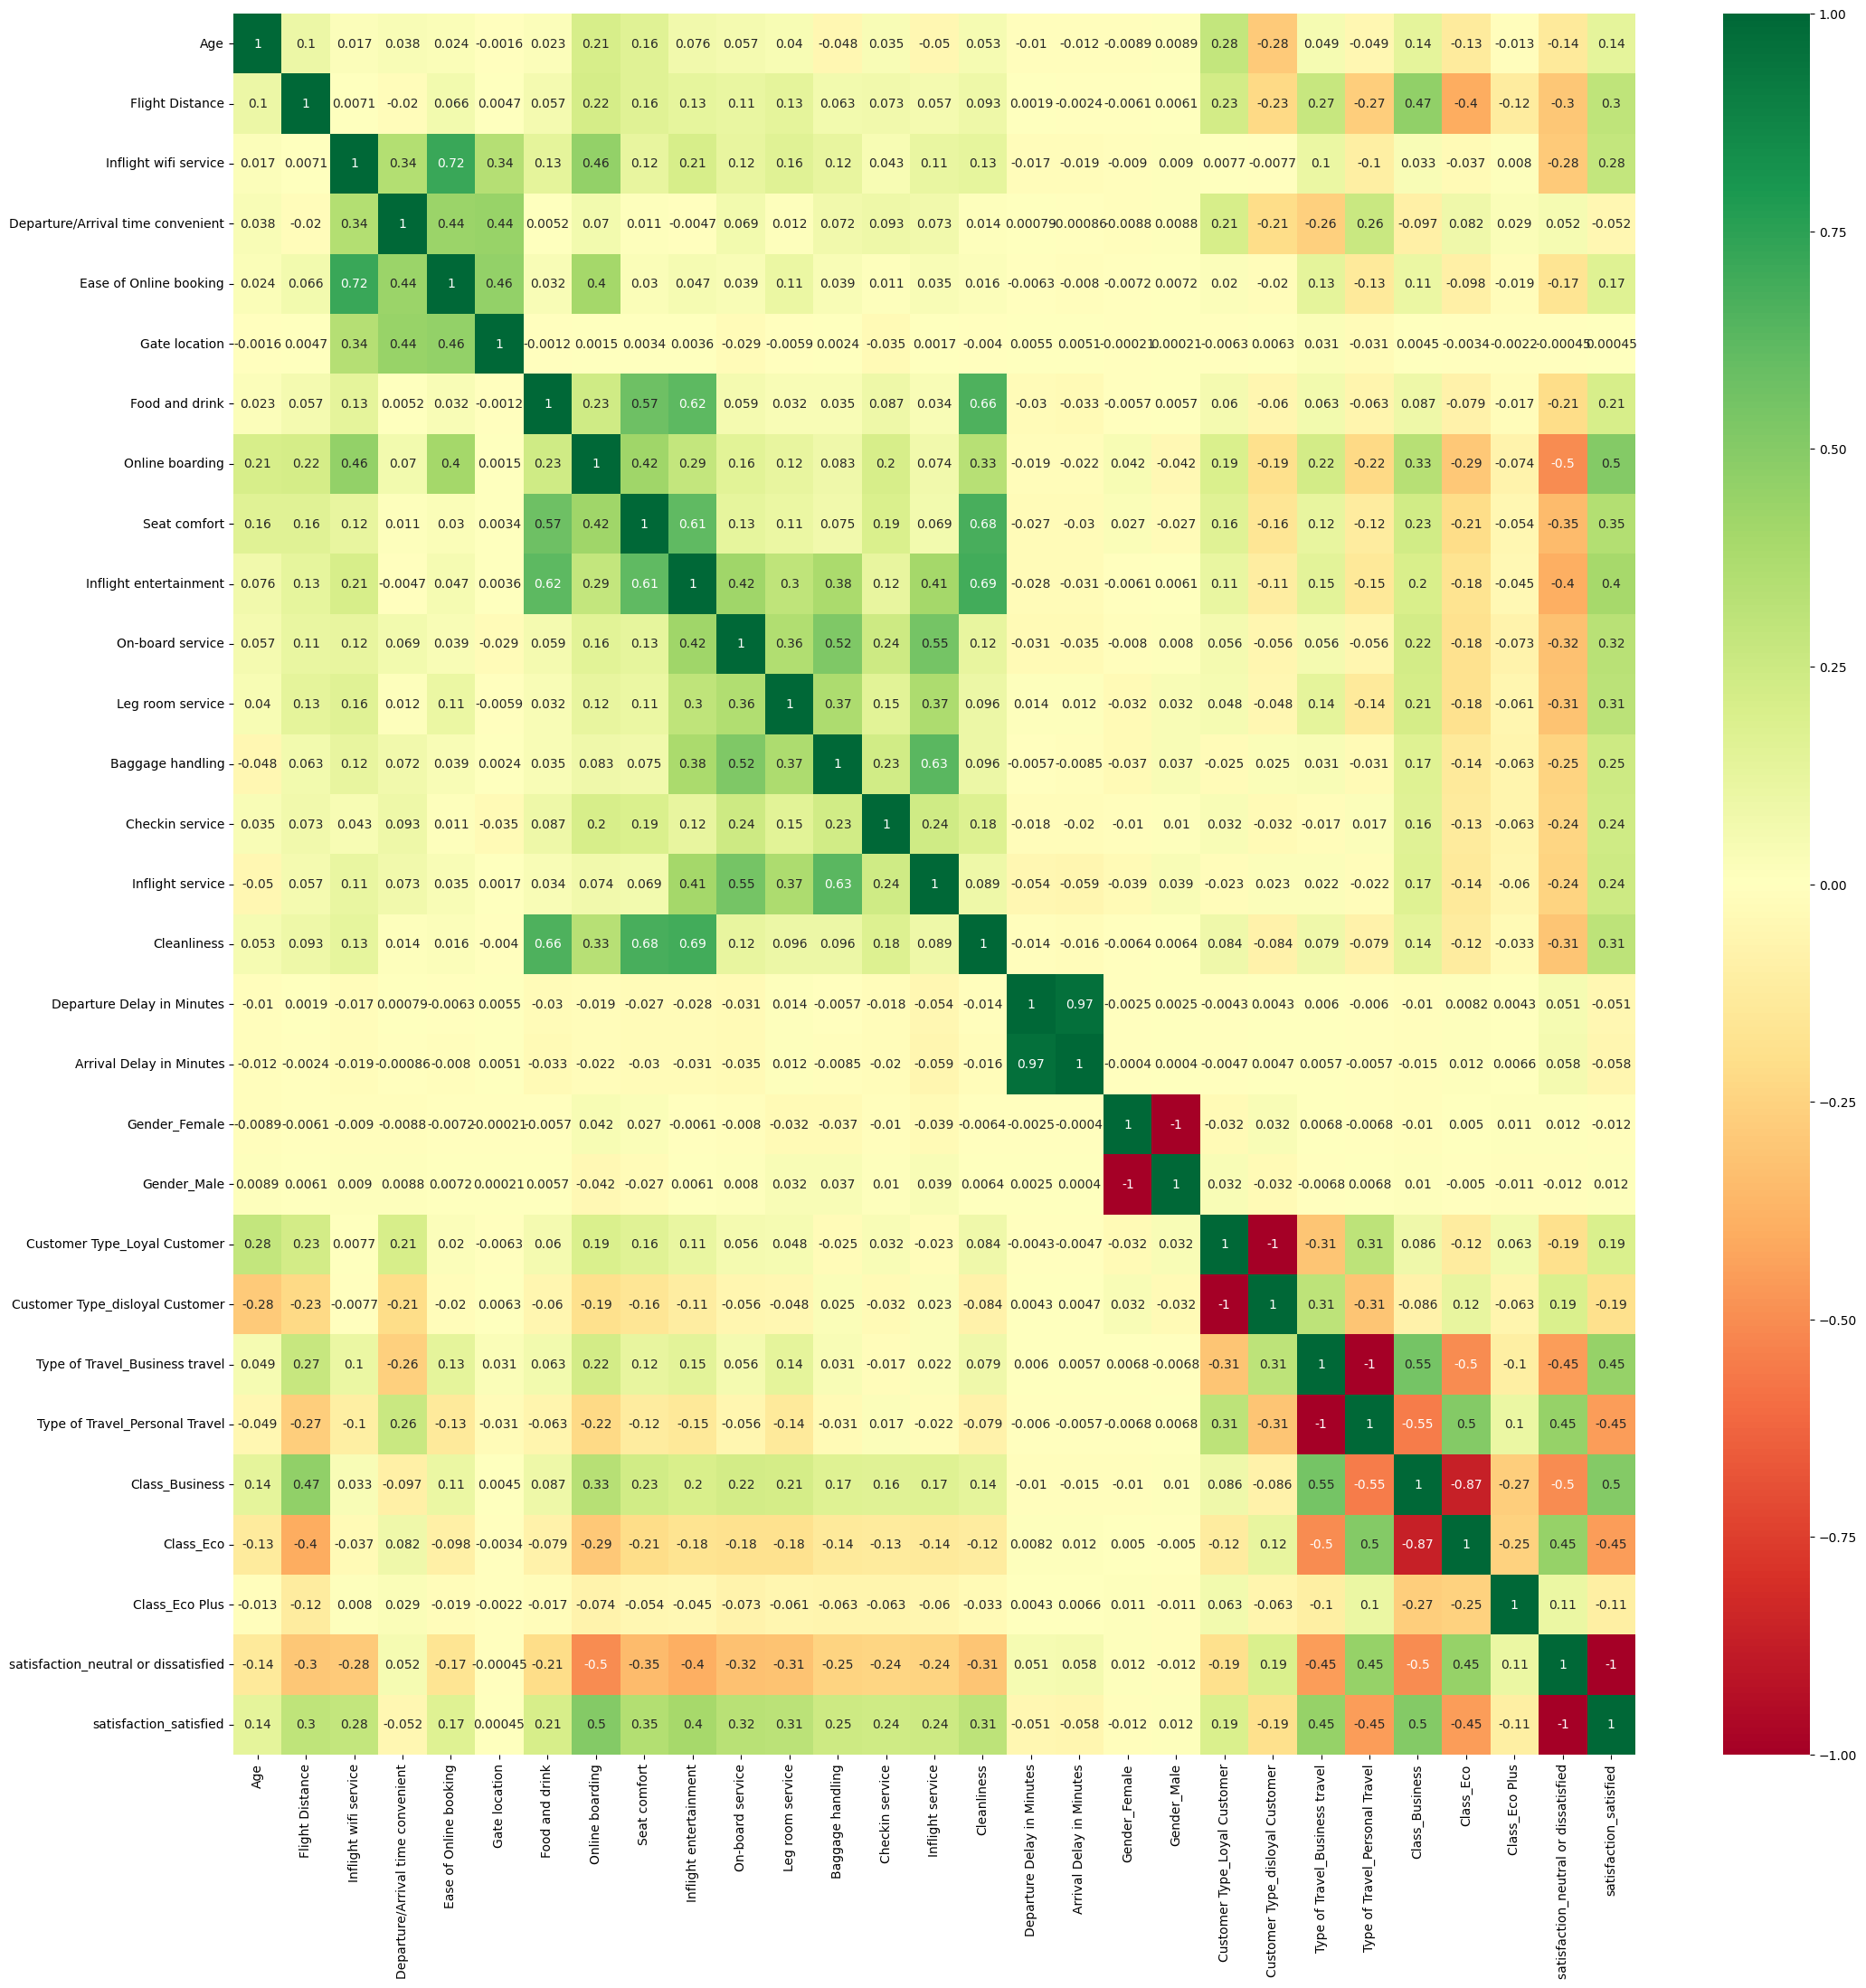

In [72]:

corr_matrix = hotdf.corr()
best_features = corr_matrix.index
plt.figure(figsize=(25,25))
hot = sns.heatmap(hotdf[best_features].corr(),annot=True,cmap="RdYlGn")


## RBF SVM Classification

In [73]:
y = hotdf['satisfaction_neutral or dissatisfied']
#x = hotdf[['Class_Eco', 'Type of Travel_Personal Travel']].copy()
x = hotdf.drop(columns={'satisfaction_neutral or dissatisfied', 'satisfaction_satisfied'})

# The dataset is so big that I need to cut it down
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

clf = svm.SVC(kernel='rbf', gamma=0.1)
clf.fit(x_train, y_train)
print("Done Fitting the Model")
y_pred = clf.predict(x_test)

p,r,f,s = precision_recall_fscore_support(y_test, y_pred)

print(f'Per: {p}')
print(f'Rec: {r}')
print(f'F1: {f}')

Done Fitting the Model
Per: [0.94462151 0.92012952]
Rec: [0.88901387 0.96083404]
F1: [0.9159745  0.94004135]


## Feature Importance

In [74]:
perm_importance = permutation_importance(clf, x_test, y_test, n_jobs=-1, n_repeats=5)
print("Done with Importance Stuff")
sorted_idx = perm_importance.importances_mean.argsort()

for i in sorted_idx:
    print(x.columns[i])
    
# This changes based on the run, but Food and Drink is almost always in the top 10. This is the first thing that airlines can actually change/do proactivly. 

Done with Importance Stuff
Gender_Male
Gender_Female
Food and drink
Flight Distance
Gate location
Inflight service
Class_Eco Plus
Departure Delay in Minutes
Arrival Delay in Minutes
Class_Eco
Baggage handling
Departure/Arrival time convenient
Age
Leg room service
Seat comfort
Cleanliness
On-board service
Inflight entertainment
Checkin service
Class_Business
Customer Type_Loyal Customer
Customer Type_disloyal Customer
Online boarding
Ease of Online booking
Type of Travel_Business travel
Type of Travel_Personal Travel
Inflight wifi service


## Lets try Poly

In [75]:
clf = svm.SVC(kernel='poly', degree=2)
clf.fit(x_train, y_train)
print("Done Fitting the Model")
y_pred = clf.predict(x_test)

p,r,f,s = precision_recall_fscore_support(y_test, y_pred)

print(f'Per: {p}')
print(f'Rec: {r}')
print(f'F1: {f}')

Done Fitting the Model
Per: [0.94828267 0.92804779]
Rec: [0.90063742 0.96308819]
F1: [0.92384615 0.94524336]


## Now Linear SVM

In [76]:
clf = svm.SVC(kernel='linear', class_weight={0:4})
clf.fit(x_train, y_train)
print("Done Fitting the Model")
y_pred = clf.predict(x_test)

p,r,f,s = precision_recall_fscore_support(y_test, y_pred)

print(f'Per: {p}')
print(f'Rec: {r}')
print(f'F1: {f}')

Done Fitting the Model
Per: [0.74371403 0.92727273]
Rec: [0.92050994 0.76162299]
F1: [0.82272118 0.83632426]


It seems that the more weight that I add, the higher my percesion score gets. However, my recall starts to suffer. So I suppose that If I cared more about percesion than this might be a more worthwhile strategy to persue. 

## Normal Logistic Regression

In [77]:
lm = LogisticRegression()
lm.fit(x_train, y_train)
print(lm.score(x_train, y_train))

0.8756737189284852


c:\Users\scrum\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Data Visualization

Text(0, 0.5, 'Inflight Service Rating')

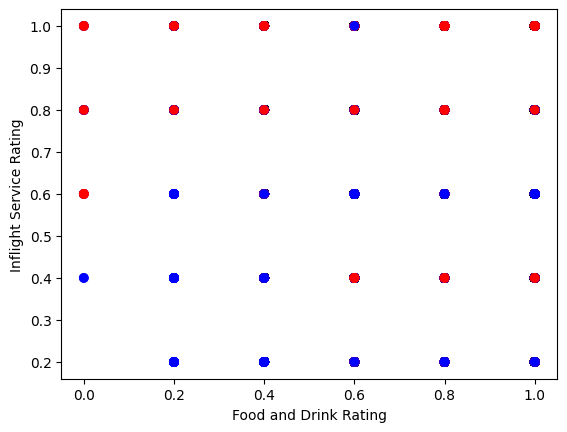

In [80]:
plotx = x_train[['Food and drink', 'Inflight service']]
ploty = y_train
color = ['r' if ploty_ == 0 else 'b' for ploty_ in y_train]
plt.scatter(x_train['Food and drink'], x_train['Inflight service'], c=color)
plt.xlabel("Food and Drink Rating")
plt.ylabel("Inflight Service Rating")

This graph is a bit misleading, as the dots cover up eachother. However if we look at the surface level we can see some clustering that could be assumed.